In [1]:
!pip install mujoco
!pip install ffmpeg

# Set up GPU rendering.
import distutils.util
import os
import subprocess

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


""

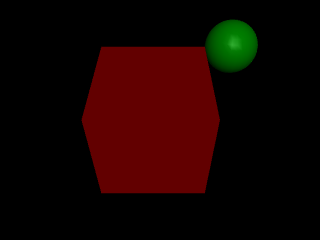

In [2]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".3 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
with mujoco.Renderer(model) as renderer:
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)

    media.show_image(renderer.render())

""

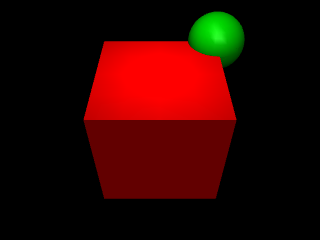

In [3]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

# Run this cell multiple times for different colors
model.geom('red_box').rgba[:3] = np.random.rand(3)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [4]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".1 .1 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3.8  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

""

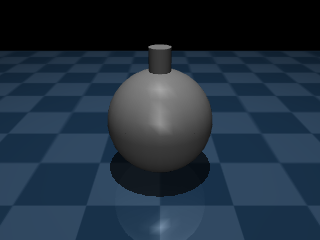

In [5]:
tippe_top = """
<mujoco model="tippe top">
  <option integrator="RK4"/>

  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300"/>
    <material name="grid" texture="grid" texrepeat="8 8" reflectance=".2"/>
  </asset>

  <worldbody>
    <geom size=".2 .2 .01" type="plane" material="grid"/>
    <light pos="0 0 .6"/>
    <camera name="closeup" pos="0 -.1 .07" xyaxes="1 0 0 0 1 2"/>
    <body name="top" pos="0 0 .02">
      <freejoint/>
      <geom name="ball" type="sphere" size=".02" />
      <geom name="stem" type="cylinder" pos="0 0 .02" size="0.004 .008"/>
      <geom name="ballast" type="box" size=".023 .023 0.005"  pos="0 0 -.015"
       contype="0" conaffinity="0" group="3"/>
    </body>
  </worldbody>

  <keyframe>
    <key name="spinning" qpos="0 0 0.02 1 0 0 0" qvel="0 0 0 0 1 200" />
  </keyframe>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(tippe_top)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data, camera="closeup")

  media.show_image(renderer.render())

In [11]:
scene_hand = """<mujoco model="right_allegro_hand scene">
  <include file="right_hand.xml"/>

  <statistic center="0 0 0" extent="0.3"/>

  <visual>
    <rgba haze="0.15 0.25 0.35 1"/>
    <quality shadowsize="8192"/>
    <global azimuth="130" elevation="-40"/>
  </visual>

  <asset>
    <texture type="skybox" builtin="gradient" rgb1="0.3 0.5 0.7" rgb2="0 0 0" width="512" height="3072"/>
    <texture type="2d" name="groundplane" builtin="checker" mark="edge" rgb1="0.2 0.3 0.4" rgb2="0.1 0.2 0.3"
      markrgb="0.8 0.8 0.8" width="300" height="300"/>
    <material name="groundplane" texture="groundplane" texuniform="true" texrepeat="5 5" reflectance="0.2"/>
  </asset>

  <worldbody>
    <light pos="0 0 1"/>
    <light pos="0.3 0 1.5" dir="0 0 -1" directional="true"/>
    <geom name="floor" pos="0 0 -0.1" size="0 0 0.05" type="plane" material="groundplane"/>
    <body name="object" pos="0 0 0.1">
      <freejoint/>
      <geom type="ellipsoid" size="0.03 0.04 0.02" rgba="0.5 0.7 0.5 1" condim="6" priority="1"
        friction="0.7 0.002 0.002"/>
    </body>
  </worldbody>
</mujoco>"""

In [8]:
allegro_hand = """<mujoco model="allegro_right">
  <compiler angle="radian" meshdir="assets" autolimits="true"/>

  <option cone="elliptic" impratio="10"/>

  <default>
    <default class="allegro_right">
      <joint axis="0 1 0" damping=".1"/>
      <position kp="1"/>
      <geom density="800"/>

      <default class="visual">
        <geom type="mesh" contype="0" conaffinity="0" group="2" material="black"/>
        <default class="palm_visual">
          <geom mesh="base_link"/>
        </default>
        <default class="base_visual">
          <geom mesh="link_0.0"/>
        </default>
        <default class="proximal_visual">
          <geom mesh="link_1.0"/>
        </default>
        <default class="medial_visual">
          <geom mesh="link_2.0"/>
        </default>
        <default class="distal_visual">
          <geom mesh="link_3.0"/>
        </default>
        <default class="fingertip_visual">
          <geom pos="0 0 0.0267" material="white" mesh="link_3.0_tip"/>
        </default>
        <default class="thumbtip_visual">
          <geom pos="0 0 0.0423" material="white" mesh="link_15.0_tip"/>
        </default>
      </default>

      <default class="collision">
        <geom group="3" type="box" mass="0"/>
        <default class="palm_collision">
          <geom size="0.0204 0.0565 0.0475" pos="-0.0093 0 -0.0475"/>
        </default>
        <default class="base_collision">
          <geom size="0.0098 0.01375 0.0082" pos="0 0 0.0082"/>
          <default class="thumb_base_collision">
            <geom size="0.0179 0.017 0.02275" pos="-0.0179 0.009 0.0145"/>
          </default>
        </default>
        <default class="proximal_collision">
          <geom size="0.0098 0.01375 0.027" pos="0 0 0.027"/>
          <default class="thumb_proximal_collision">
            <geom size="0.0098 0.01375 0.00885" pos="0 0 0.00885"/>
          </default>
        </default>
        <default class="medial_collision">
          <geom size="0.0098 0.01375 0.0192" pos="0 0 0.0192"/>
          <default class="thumb_medial_collision">
            <geom size="0.0098 0.01375 0.0257" pos="0 0 0.0257"/>
          </default>
        </default>
        <default class="distal_collision">
          <geom size="0.0098 0.01375 0.008" pos="0 0 0.008"/>
          <default class="thumb_distal_collision">
            <geom size="0.0098 0.01375 0.0157" pos="0 0 0.0157"/>
          </default>
        </default>
        <default class="fingertip_collision">
          <geom type="capsule" size="0.012 0.01" pos="0 0 0.019"/>
          <default class="thumbtip_collision">
            <geom type="capsule" size="0.012 0.008" pos="0 0 0.035"/>
          </default>
        </default>
      </default>

      <default class="base">
        <joint axis="0 0 1" range="-0.47 0.47"/>
        <position ctrlrange="-0.47 0.47"/>
      </default>
      <default class="proximal">
        <joint range="-0.196 1.61"/>
        <position ctrlrange="-0.196 1.61"/>
      </default>
      <default class="medial">
        <joint range="-0.174 1.709"/>
        <position ctrlrange="-0.174 1.709"/>
      </default>
      <default class="distal">
        <joint range="-0.227 1.618"/>
        <position ctrlrange="-0.227 1.618"/>
      </default>
      <default class="thumb_base">
        <joint axis="-1 0 0" range="0.263 1.396"/>
        <position ctrlrange="0.263 1.396"/>
      </default>
      <default class="thumb_proximal">
        <joint axis="0 0 1" range="-0.105 1.163"/>
        <position ctrlrange="-0.105 1.163"/>
      </default>
      <default class="thumb_medial">
        <joint range="-0.189 1.644"/>
        <position ctrlrange="-0.189 1.644"/>
      </default>
      <default class="thumb_distal">
        <joint range="-0.162 1.719"/>
        <position ctrlrange="-0.162 1.719"/>
      </default>
    </default>
  </default>

  <asset>
    <material name="black" rgba="0.2 0.2 0.2 1"/>
    <material name="white" rgba="0.9 0.9 0.9 1"/>

    <mesh file="base_link.stl"/>
    <mesh file="link_0.0.stl"/>
    <mesh file="link_1.0.stl"/>
    <mesh file="link_2.0.stl"/>
    <mesh file="link_3.0.stl"/>
    <mesh file="link_3.0_tip.stl"/>
    <mesh file="link_12.0_right.stl"/>
    <mesh file="link_13.0.stl"/>
    <mesh file="link_14.0.stl"/>
    <mesh file="link_15.0.stl"/>
    <mesh file="link_15.0_tip.stl"/>
  </asset>

  <worldbody>
    <body name="palm" quat="0 1 0 1" childclass="allegro_right">
      <!-- <inertial mass="0.4154" pos="0 0 0.0475" diaginertia="1e-4 1e-4 1e-4"/> -->
      <geom class="palm_visual" mesh="base_link"/>
      <geom class="palm_collision"/>
      <!-- First finger -->
      <body name="ff_base" pos="0 0.0435 -0.001542" quat="0.999048 -0.0436194 0 0">
        <joint name="ffj0" class="base"/>
        <geom class="base_visual"/>
        <geom class="base_collision"/>
        <body name="ff_proximal" pos="0 0 0.0164">
          <joint name="ffj1" class="proximal"/>
          <geom class="proximal_visual"/>
          <geom class="proximal_collision"/>
          <body name="ff_medial" pos="0 0 0.054">
            <joint name="ffj2" class="medial"/>
            <geom class="medial_visual"/>
            <geom class="medial_collision"/>
            <body name="ff_distal" pos="0 0 0.0384">
              <joint name="ffj3" class="distal"/>
              <geom class="distal_visual"/>
              <geom class="distal_collision"/>
              <body name="ff_tip">
                <geom class="fingertip_visual"/>
                <geom class="fingertip_collision"/>
              </body>
            </body>
          </body>
        </body>
      </body>
      <!-- Middle finger -->
      <body name="mf_base" pos="0 0 0.0007">
        <joint name="mfj0" class="base"/>
        <geom class="base_visual"/>
        <geom class="base_collision"/>
        <body name="mf_proximal" pos="0 0 0.0164">
          <joint name="mfj1" class="proximal"/>
          <geom class="proximal_visual"/>
          <geom class="proximal_collision"/>
          <body name="mf_medial" pos="0 0 0.054">
            <joint name="mfj2" class="medial"/>
            <geom class="medial_visual"/>
            <geom class="medial_collision"/>
            <body name="mf_distal" pos="0 0 0.0384">
              <joint name="mfj3" class="distal"/>
              <geom class="distal_visual"/>
              <geom class="distal_collision"/>
              <body name="mf_tip">
                <geom class="fingertip_visual"/>
                <geom class="fingertip_collision"/>
              </body>
            </body>
          </body>
        </body>
      </body>
      <!-- Ring finger -->
      <body name="rf_base" pos="0 -0.0435 -0.001542" quat="0.999048 0.0436194 0 0">
        <joint name="rfj0" class="base"/>
        <geom class="base_visual"/>
        <geom class="base_collision"/>
        <body name="rf_proximal" pos="0 0 0.0164">
          <joint name="rfj1" class="proximal"/>
          <geom class="proximal_visual"/>
          <geom class="proximal_collision"/>
          <body name="rf_medial" pos="0 0 0.054">
            <joint name="rfj2" class="medial"/>
            <geom class="medial_visual"/>
            <geom class="medial_collision"/>
            <body name="rf_distal" pos="0 0 0.0384">
              <joint name="rfj3" class="distal"/>
              <geom class="distal_visual"/>
              <geom class="distal_collision"/>
              <body name="rf_tip">
                <geom class="fingertip_visual"/>
                <geom class="fingertip_collision"/>
              </body>
            </body>
          </body>
        </body>
      </body>
      <!-- Thumb -->
      <body name="th_base" pos="-0.0182 0.019333 -0.045987" quat="0.477714 -0.521334 -0.521334 -0.477714">
        <joint name="thj0" class="thumb_base"/>
        <geom class="visual" mesh="link_12.0_right"/>
        <geom class="thumb_base_collision"/>
        <body name="th_proximal" pos="-0.027 0.005 0.0399">
          <joint name="thj1" class="thumb_proximal"/>
          <geom class="visual" mesh="link_13.0"/>
          <geom class="thumb_proximal_collision"/>
          <body name="th_medial" pos="0 0 0.0177">
            <joint name="thj2" class="thumb_medial"/>
            <geom class="visual" mesh="link_14.0"/>
            <geom class="thumb_medial_collision"/>
            <body name="th_distal" pos="0 0 0.0514">
              <joint name="thj3" class="thumb_distal"/>
              <geom class="visual" mesh="link_15.0"/>
              <geom class="thumb_distal_collision"/>
              <body name="th_tip">
                <geom class="thumbtip_visual"/>
                <geom class="thumbtip_collision"/>
              </body>
            </body>
          </body>
        </body>
      </body>
    </body>
  </worldbody>

  <contact>
    <exclude body1="palm" body2="ff_base"/>
    <exclude body1="palm" body2="mf_base"/>
    <exclude body1="palm" body2="rf_base"/>
    <exclude body1="palm" body2="th_base"/>
    <exclude body1="palm" body2="th_proximal"/>
  </contact>

  <actuator>
    <position name="ffa0" joint="ffj0" class="base"/>
    <position name="ffa1" joint="ffj1" class="proximal"/>
    <position name="ffa2" joint="ffj2" class="medial"/>
    <position name="ffa3" joint="ffj3" class="distal"/>
    <position name="mfa0" joint="mfj0" class="base"/>
    <position name="mfa1" joint="mfj1" class="proximal"/>
    <position name="mfa2" joint="mfj2" class="medial"/>
    <position name="mfa3" joint="mfj3" class="distal"/>
    <position name="rfa0" joint="rfj0" class="base"/>
    <position name="rfa1" joint="rfj1" class="proximal"/>
    <position name="rfa2" joint="rfj2" class="medial"/>
    <position name="rfa3" joint="rfj3" class="distal"/>
    <position name="tha0" joint="thj0" class="thumb_base"/>
    <position name="tha1" joint="thj1" class="thumb_proximal"/>
    <position name="tha2" joint="thj2" class="thumb_medial"/>
    <position name="tha3" joint="thj3" class="thumb_distal"/>
  </actuator>
</mujoco>"""

""

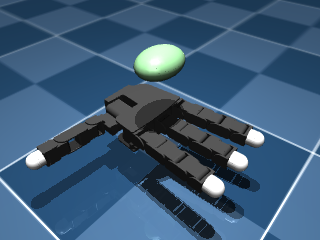

In [12]:
model = mujoco.MjModel.from_xml_string(scene_hand)
data = mujoco.MjData(model)

mujoco.mj_forward(model, data)
with mujoco.Renderer(model) as renderer:
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [14]:
xml = scene_hand
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 10  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)
with mujoco.Renderer(model) as renderer:
  while data.time < duration:
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data, scene_option=scene_option)
      pixels = renderer.render()
      frames.append(pixels)

media.show_video(frames, fps=framerate)

In [17]:
import mujoco
import mediapy as media

# Load the model
model = mujoco.MjModel.from_xml_string(allegro_hand)
data = mujoco.MjData(model)

# Enable joint visualization
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3  # (seconds)
framerate = 60  # (Hz)

# Get actuator names (from the XML)
actuator_names = [
    # First finger
    "ffa0", "ffa1", "ffa2", "ffa3",
    # Middle finger
    "mfa0", "mfa1", "mfa2", "mfa3",
    # Ring finger
    "rfa0", "rfa1", "rfa2", "rfa3",
    # Thumb
    "tha0", "tha1", "tha2", "tha3"
]

# Get actuator IDs
actuator_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name) 
                for name in actuator_names]

# Target positions for closed hand (based on joint ranges from XML)
closed_positions = [
    # First finger (ff)
    0.0, 1.61, 1.709, 1.618,  # Maximal flexion based on joint ranges
    # Middle finger (mf)
    0.0, 1.61, 1.709, 1.618,
    # Ring finger (rf)
    0.0, 1.61, 1.709, 1.618,
    # Thumb (th)
    1.396, 1.163, 1.644, 1.719  # Thumb has different ranges
]

# Simulate and display video
frames = []
mujoco.mj_resetData(model, data)

with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        # Calculate interpolation factor (0=open, 1=closed)
        close_amount = 3*min(1.0, data.time / 2.0)  # Ramp up over 2 seconds
        
        # Set control values for each actuator
        for i, act_id in enumerate(actuator_ids):
            if act_id != -1:  # Skip if actuator not found
                # Interpolate between initial position (0) and closed position
                data.ctrl[act_id] = close_amount * closed_positions[i]
        
        mujoco.mj_step(model, data)
        
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option)
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)

In [20]:
import mujoco
import mediapy as media
import numpy as np

# Load the model
model = mujoco.MjModel.from_xml_string(scene_hand)
data = mujoco.MjData(model)

# Enable joint visualization
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True

duration = 3  # (seconds)
framerate = 60  # (Hz)

# Get actuator names
actuator_names = [
    "ffa0", "ffa1", "ffa2", "ffa3",  # First finger
    "mfa0", "mfa1", "mfa2", "mfa3",  # Middle finger
    #"rfa0", "rfa1", "rfa2", "rfa3",  # Ring finger
    "tha0", "tha1", "tha2", "tha3"   # Thumb
]

# Get actuator IDs
actuator_ids = [mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, name) 
                for name in actuator_names]

# Target positions for closed hand
closed_positions = [
    # First finger
    0.0, 1.61, 1.709, 1.618,
    # Middle finger
    0.0, 1.61, 1.709, 1.618,
    # Ring finger
    #0.0, 1.61, 1.709, 1.618,
    # Thumb
    1.396, 1.163, 1.644, 1.719
]

# Get palm body ID
palm_body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "palm")

# Simulate and display video
frames = []
mujoco.mj_resetData(model, data)

# Set initial palm orientation to face downward (180° rotation around x-axis)
# The original quaternion was quat="0 1 0 1" (which is a 180° rotation around y-axis)
# We'll change it to face downward by rotating around x-axis
data.qpos[3:7] = [0.707, 0.707, 0, 0]  # This is a 90° rotation around x-axis

with mujoco.Renderer(model) as renderer:
    while data.time < duration:
        # Calculate interpolation factor (0=open, 1=closed)
        close_amount = min(1.0, data.time / 2.0)  # Ramp up over 2 seconds
        
        # Set control values for each actuator
        for i, act_id in enumerate(actuator_ids):
            if act_id != -1:  # Skip if actuator not found
                data.ctrl[act_id] = close_amount * closed_positions[i]
        
        mujoco.mj_step(model, data)
        
        if len(frames) < data.time * framerate:
            renderer.update_scene(data, scene_option=scene_option)
            pixels = renderer.render()
            frames.append(pixels)

media.show_video(frames, fps=framerate)